In [1]:
from pythtb import TBModel, WFArray, Mesh, Lattice
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define lattice vectors
lat_vecs = [[1, 0], [1 / 2, np.sqrt(3) / 2]]
# define coordinates of orbitals
orb_vecs = [[1 / 3, 1 / 3], [2 / 3, 2 / 3]]

lat = Lattice(lat_vecs, orb_vecs, periodic_dirs=...)

my_model = TBModel(lattice=lat)
delta = -0.1  # small staggered onsite term
t = -1.0

# set on-site energies
my_model.set_onsite([-delta, delta])
# set hoppings (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])

print(my_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 2
k-space dimension           = 2
periodic directions         = [0, 1]
spinful                     = False
number of spin components   = 1
number of electronic states = 2
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.000,  0.000]
  # 1 ===> [ 0.500,  0.866]
Volume of unit cell (Cartesian) = 0.866 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [ 6.283, -3.628]
  # 1 ===> [ 0.000,  7.255]
Volume of reciprocal unit cell = 45.586 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.500,  0.289]
  # 1 ===> [ 1.000,  0.577]

Orbital vectors (fractional):
  # 0 ===> [ 0.333,  0.333]
  # 1 ===> [ 0.667,  0.667]
----------------------------------------
Site energies:
  < 0 | H | 0 > =  0.100 
  < 1 | H | 1 > = -0.100 
Hoppings:
  < 0 | H | 1  + [ 0.0 ,  0.0 ] > = -1.0000+0.0000j
  < 1 | H | 0  + [ 1.0 , 

In [3]:
circ_step = 31  # number of steps in the circular path
circ_center = np.array([1 / 3, 2 / 3])  # the K point
circ_radius = 0.1  # the radius of the circular path

# construct k-point coordinate on the path
kpts = []
for i in range(circ_step):
    ang = 2 * np.pi * i / (circ_step - 1)
    kpt = np.array([np.cos(ang) * circ_radius, np.sin(ang) * circ_radius])
    kpt += circ_center
    kpts.append(kpt)
kpts = np.array(kpts)

In [4]:
mesh = Mesh(["k"], dim_k=2)
mesh.build_custom(kpts)
print(mesh)

Mesh Summary
Type: path
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 31
Full shape: (31, 2)
k-axes: [Axis(type=k, name=k_0, size=31)]
λ-axes: []
Loops: (axis 0, comp 0, winds_bz=no, closed=yes), (axis 0, comp 1, winds_bz=no, closed=yes)


In [5]:
w_circ = WFArray(my_model.lattice, mesh)

In [6]:
w_circ.solve_model(my_model)

In [7]:
berry_phase_0 = w_circ.berry_phase(0, [0])
berry_phase_1 = w_circ.berry_phase(0, [1])
berry_phase_both = w_circ.berry_phase(0, [0, 1])

print(
    f"Berry phase along circle with radius {circ_radius} and centered at k-point {circ_center}"
)
print(f"for band 0 equals     : {berry_phase_0: .7f}")
print(f"for band 1 equals     : {berry_phase_1: .7f}")
print(f"for both bands equals : {berry_phase_both: .7f}")

Berry phase along circle with radius 0.1 and centered at k-point [0.33333333 0.66666667]
for band 0 equals     :  2.5636831
for band 1 equals     : -2.5636831
for both bands equals :  0.0000000


In [8]:
square_step = 50
square_center = np.array([1 / 3, 2 / 3])
square_length = np.sqrt(np.pi * circ_radius**2)

all_kpt = np.zeros((square_step, square_step, 2))
for i in range(square_step):
    for j in range(square_step):
        kpt = np.array(
            [
                square_length * (-0.5 + i / (square_step - 1)),
                square_length * (-0.5 + j / (square_step - 1)),
            ]
        )
        kpt += square_center
        all_kpt[i, j, :] = kpt

In [9]:
mesh = Mesh(["k", "k"])
mesh.build_custom(points=all_kpt)
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 2500
Full shape: (50, 50, 2)
k-axes: [Axis(type=k, name=k_0, size=50), Axis(type=k, name=k_1, size=50)]
λ-axes: []
Is a torus in k-space (all k-axes wind BZ): no
Loops: None


In [10]:
w_square = WFArray(my_model.lattice, mesh)
w_square.solve_model(my_model)

In [11]:
b_flux_0 = w_square.berry_flux(state_idx=[0], plane=(0, 1))
b_flux_1 = w_square.berry_flux(state_idx=[1], plane=(0, 1))
b_flux_both = w_square.berry_flux(state_idx=[0, 1], plane=(0, 1))

print(
    f"Berry flux on square patch with length: {square_length} and centered at k-point: {square_center}"
)
print("for band 0 equals    : ", np.sum(b_flux_0))
print("for band 1 equals    : ", np.sum(b_flux_1))
print("for both bands equals: ", np.sum(b_flux_both))

Berry flux on square patch with length: 0.1772453850905516 and centered at k-point: [0.33333333 0.66666667]
for band 0 equals    :  2.566799155062844
for band 1 equals    :  -2.566799155062845
for both bands equals:  -1.444739029166154e-15


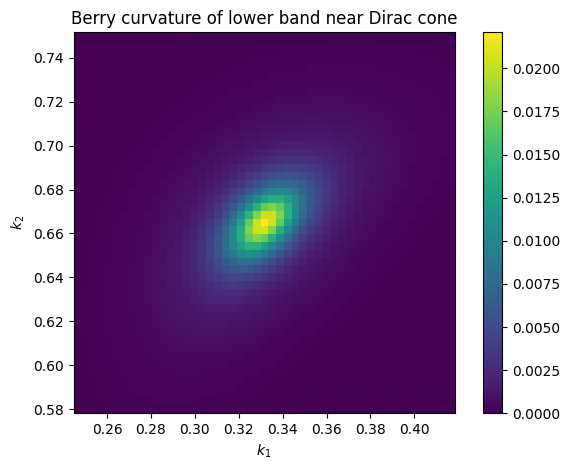

In [12]:
fig, ax = plt.subplots()
img = ax.imshow(
    b_flux_0.real,
    origin="lower",
    extent=(
        all_kpt[0, 0, 0],
        all_kpt[-2, 0, 0],
        all_kpt[0, 0, 1],
        all_kpt[0, -2, 1],
    ),
    vmax=np.amax(b_flux_0.real),
    vmin=0,
)
ax.set_title("Berry curvature of lower band near Dirac cone")
ax.set_xlabel(r"$k_1$")
ax.set_ylabel(r"$k_2$")
plt.colorbar(img)
fig.tight_layout()

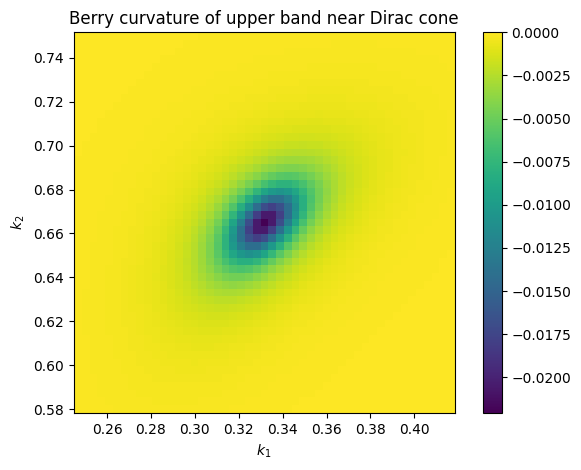

In [13]:
fig, ax = plt.subplots()
img = ax.imshow(
    b_flux_1.real,
    origin="lower",
    extent=(
        all_kpt[0, 0, 0],
        all_kpt[-2, 0, 0],
        all_kpt[0, 0, 1],
        all_kpt[0, -2, 1],
    ),
    vmax=0,
    vmin=np.amin(b_flux_1.real),
)
ax.set_title("Berry curvature of upper band near Dirac cone")
ax.set_xlabel(r"$k_1$")
ax.set_ylabel(r"$k_2$")
plt.colorbar(img)
fig.tight_layout()